In [2]:
from PIL import Image
import torch

In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import matplotlib.pyplot as plt

class CellDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "img"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "groundtruth"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "img", self.imgs[idx])
        mask_path = os.path.join(self.root, "groundtruth", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [6]:
from model.engine import train_one_epoch, evaluate
import model.utils
import model.transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

ModuleNotFoundError: No module named 'coco_utils'

In [3]:
dataset = CellDataset('data', get_transform(train=True))
dataset_test = CellDataset('data', get_transform(train=False))

NameError: name 'get_transform' is not defined

In [6]:
img, _ = dataset_test[12]

In [7]:
PATH = "obj_det_model.pt"


net = torch.load(PATH, map_location=torch.device('cpu'))

In [8]:
net.eval()
with torch.no_grad():
    prediction = net([img])

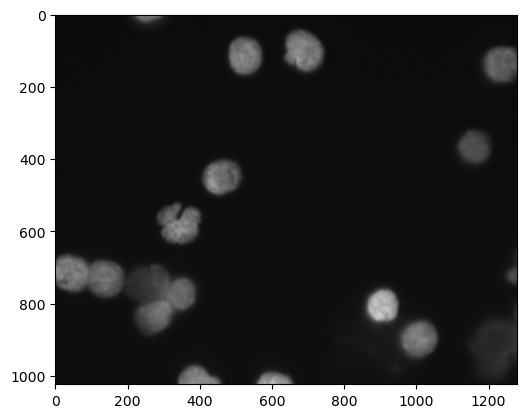

In [12]:
plt.imshow(Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy()), cmap="gray")

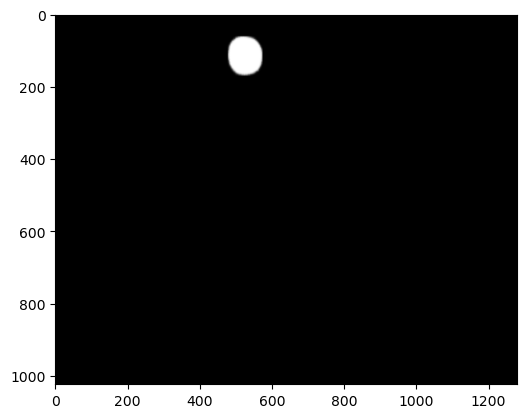

In [15]:
plt.imshow(Image.fromarray(prediction[0]['masks'][1, 0].mul(255).byte().cpu().numpy()), cmap="gray")

In [17]:
prediction[0]['masks'].shape

torch.Size([21, 1, 1024, 1280])

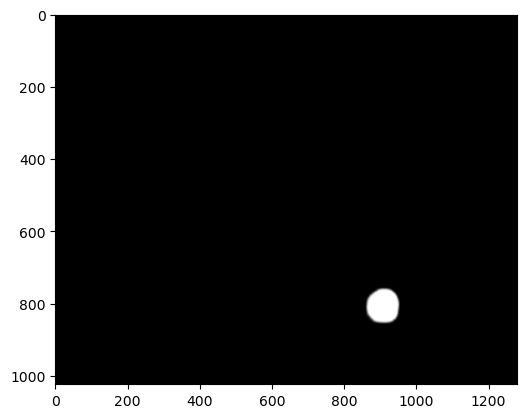

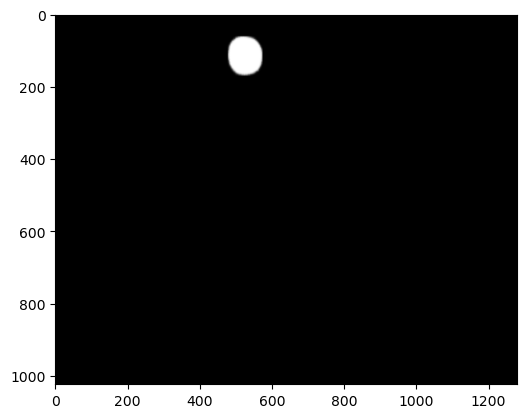

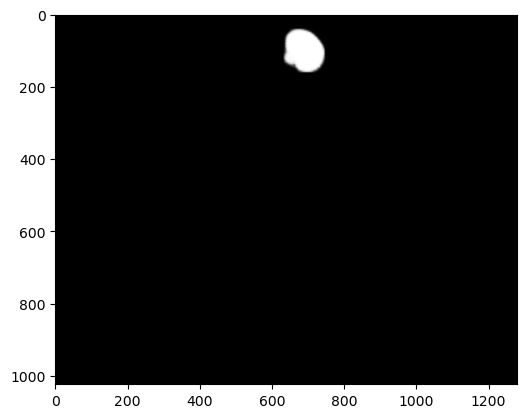

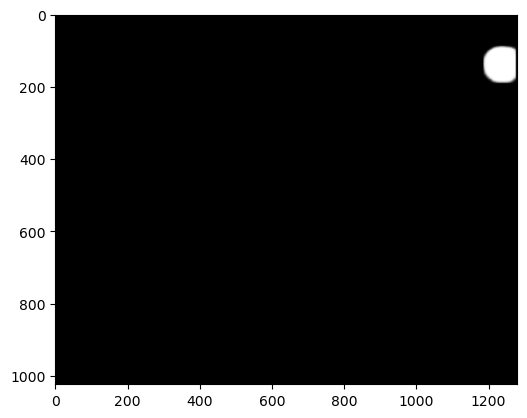

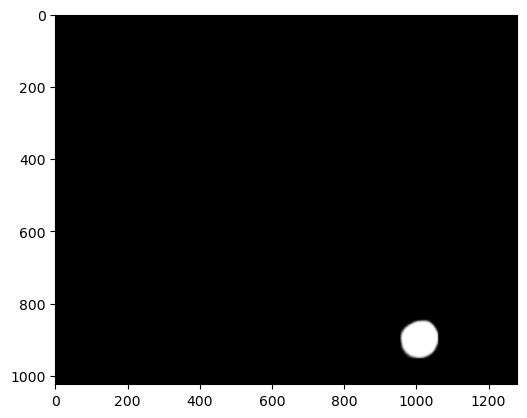

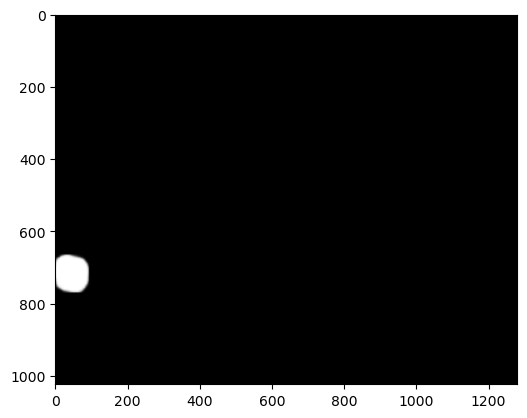

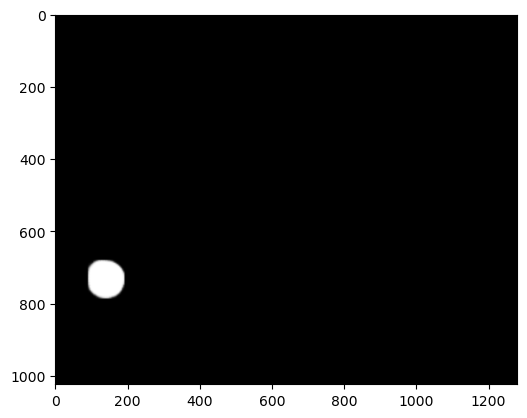

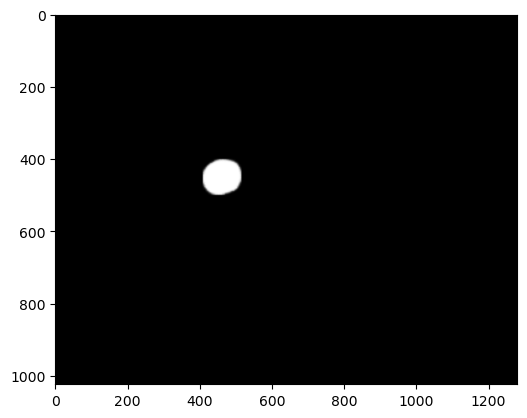

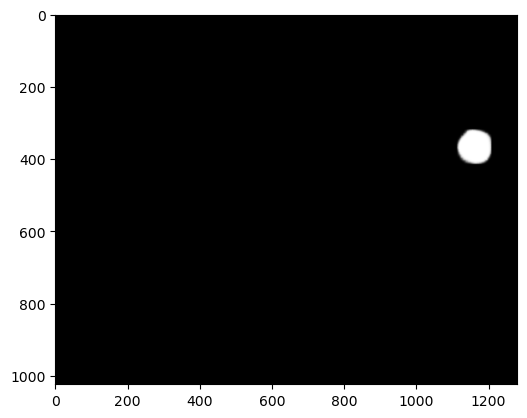

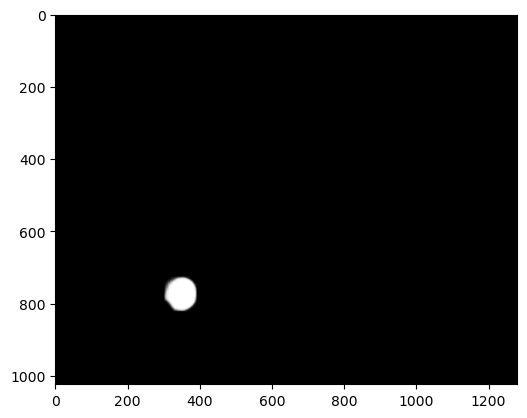

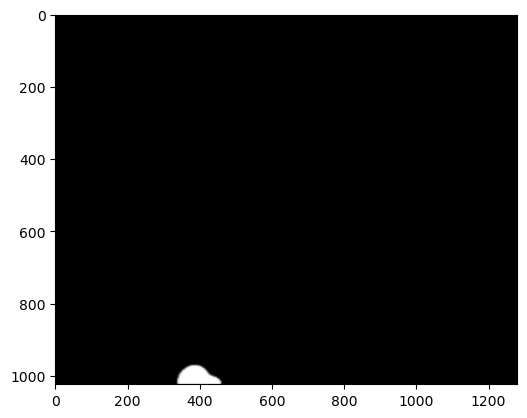

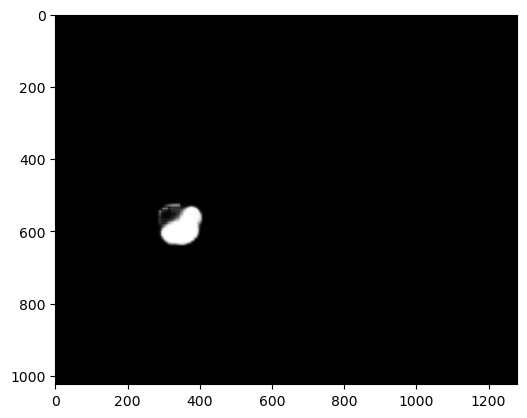

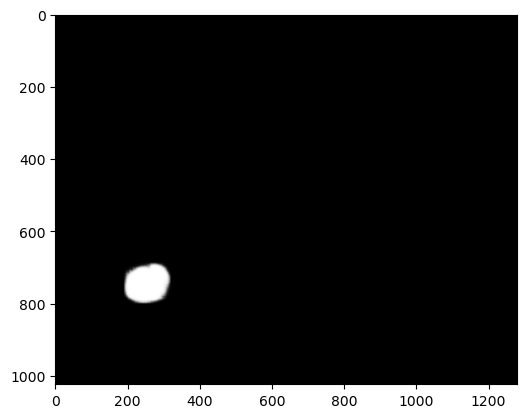

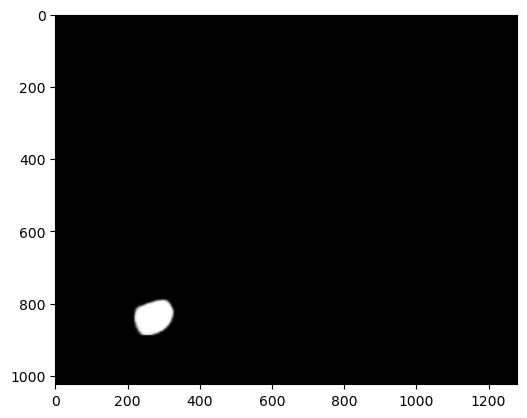

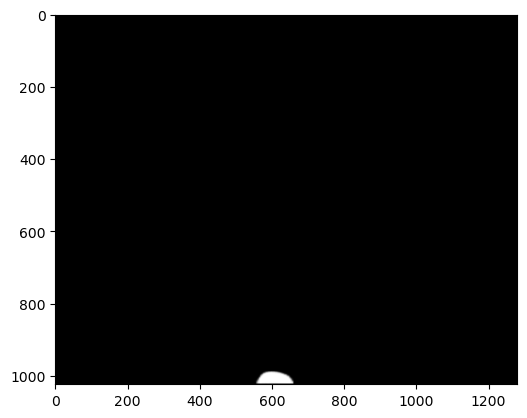

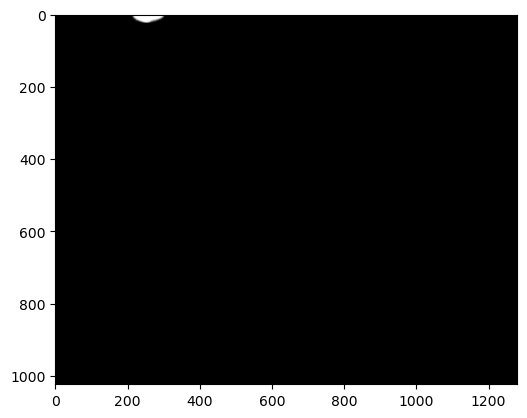

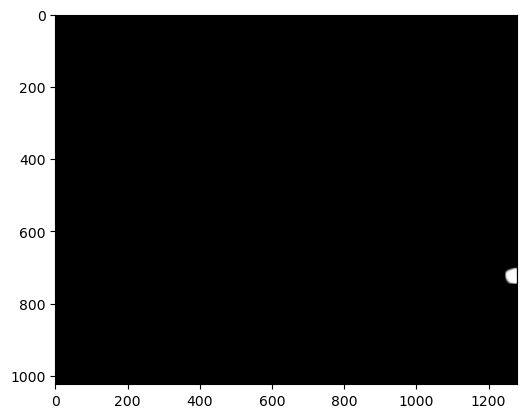

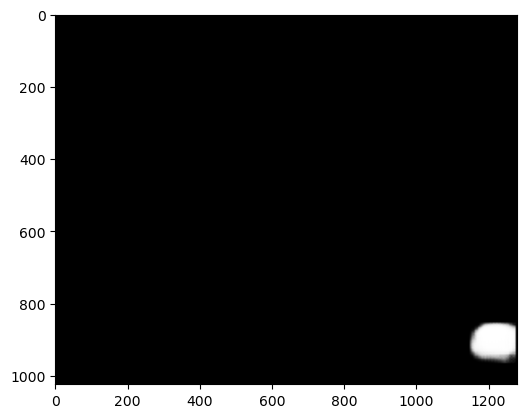

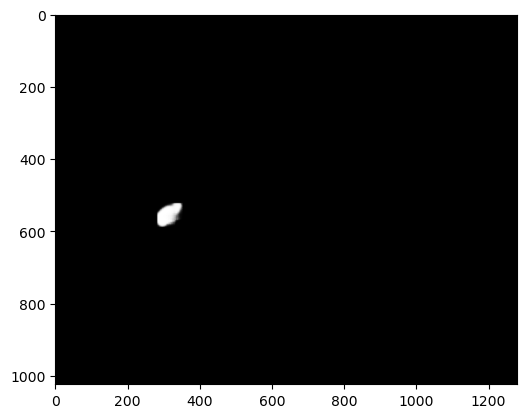

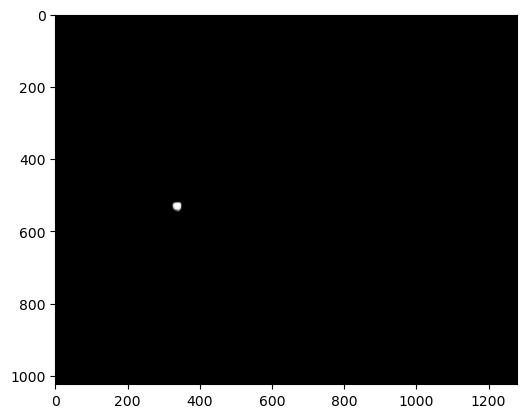

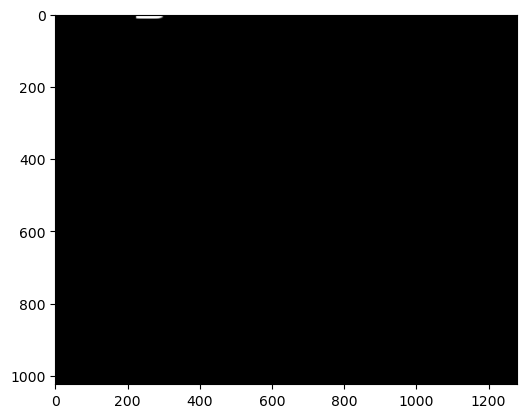

In [19]:
for i in range(21):
    plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()), cmap="gray")
    plt.show()

In [28]:
import cv2


def load_bw_image(infilename):
    img = Image.open(infilename)
    img.load()
    data = np.asarray(img.convert('L'), dtype="uint8")
    return data

def get_slices(img_input, n=10, m=12):
    M = img_input.shape[0]//n
    N = img_input.shape[1]//m
    arr_of_imgs = [img_input[x:x+M, y:y+N] for x in range(0, img_input.shape[0], M) for y in range(0, img_input.shape[1], N)]
    return arr_of_imgs


def get_mask(np_img_input, minval=200, maxval=300):
    hsv_lower = np.array([minval])
    hsv_upper = np.array([maxval])
    return cv2.inRange(np_img_input, hsv_lower, hsv_upper)


def laplacian_edge_det(np_img_input, contr_scale=50):
    blur = cv2.GaussianBlur(np_img_input.astype(np.uint8), (5, 5), 0, 0)
    # scale increases the contrast
    edge_LoG = cv2.Laplacian(blur, cv2.CV_8U, 3, scale=50)
    return edge_LoG

In [29]:
IMG_PATH = '../kepek\A1.jpeg'
np_img = load_bw_image(IMG_PATH)

slices = get_slices(np_img, 10, 12)
print(len(slices))

one_slice = slices[93]
edges = laplacian_edge_det(one_slice)

mask = get_mask(edges)


143


In [37]:
m = Image.fromarray(one_slice)
m.save('./res/img/base.jpg')

In [51]:
dataset = CellDataset('./data/augmented/', get_transform(train=False))

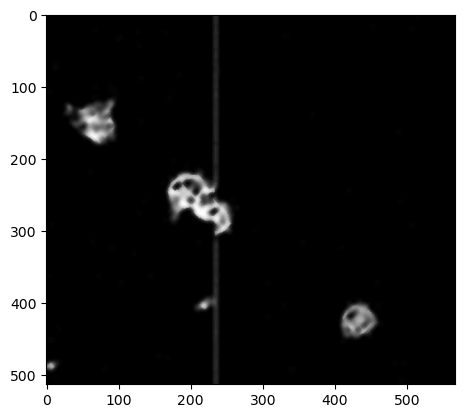

In [56]:
img, _ = dataset_test[0]
plt.imshow(Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy()), cmap="gray")

In [57]:
net.eval()
with torch.no_grad():
    prediction = net([img])

In [58]:
prediction[0]['masks'].shape

torch.Size([42, 1, 513, 567])

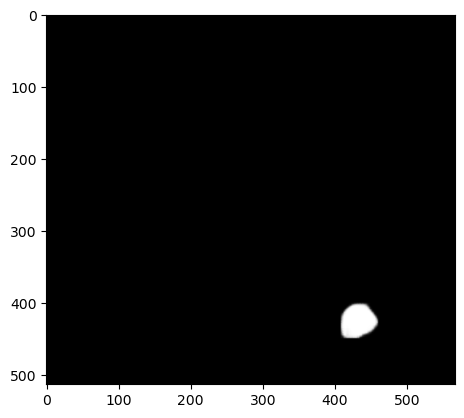

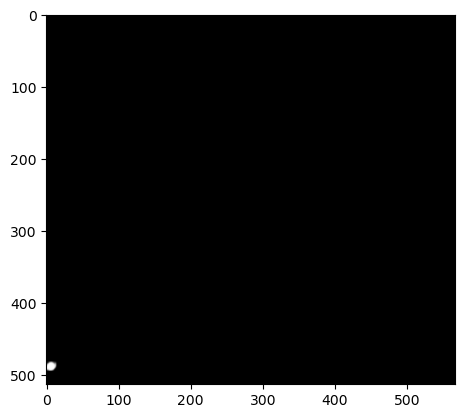

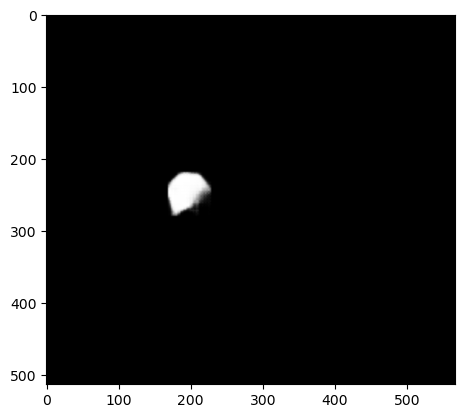

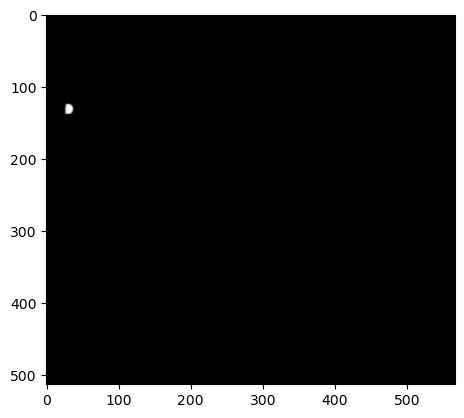

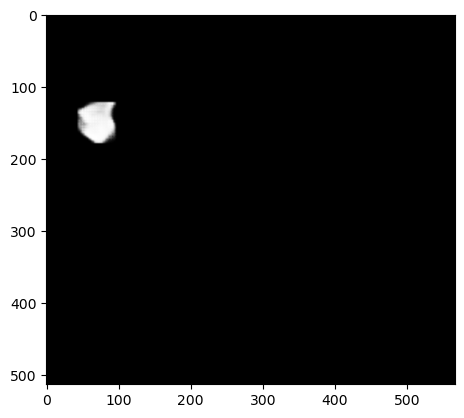

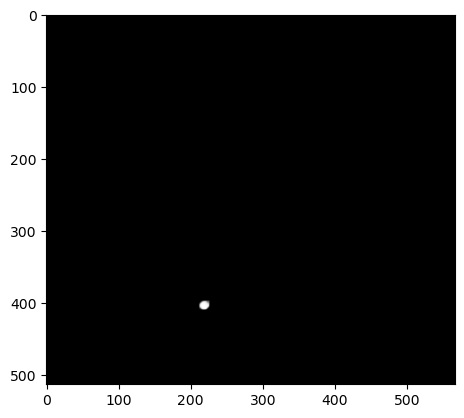

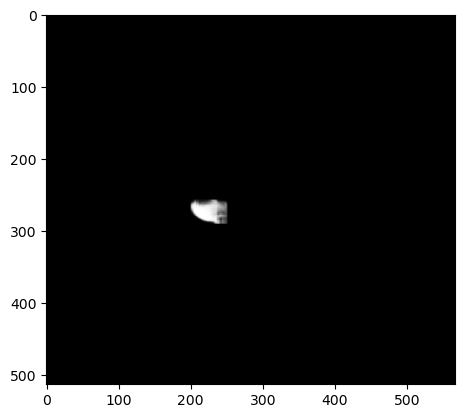

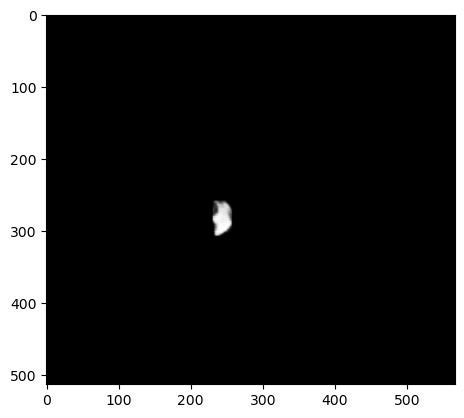

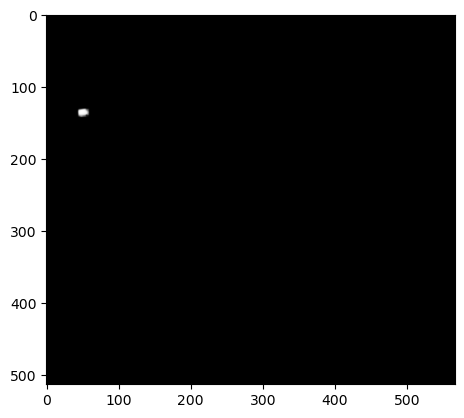

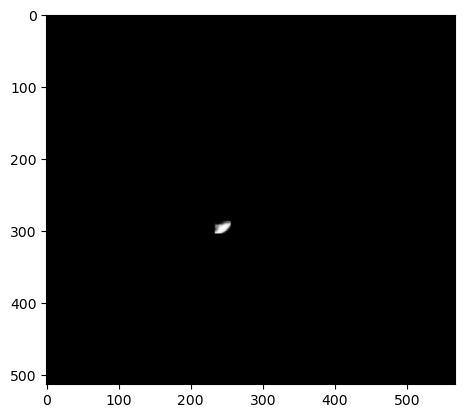

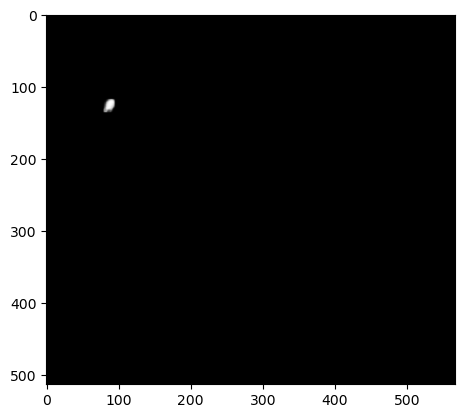

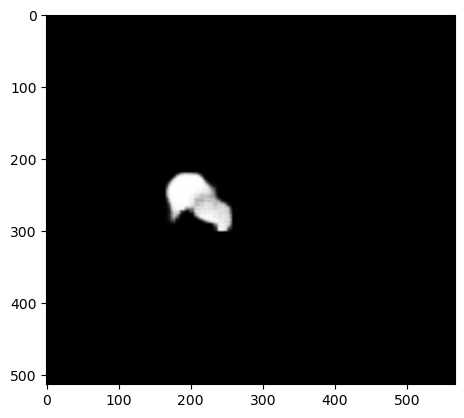

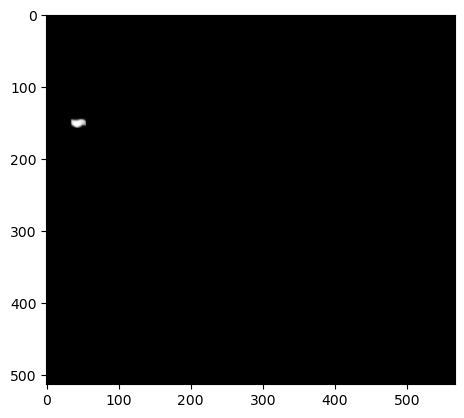

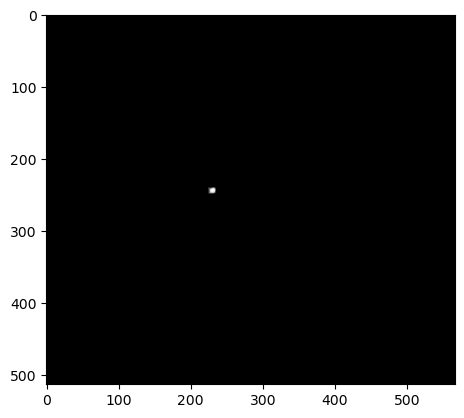

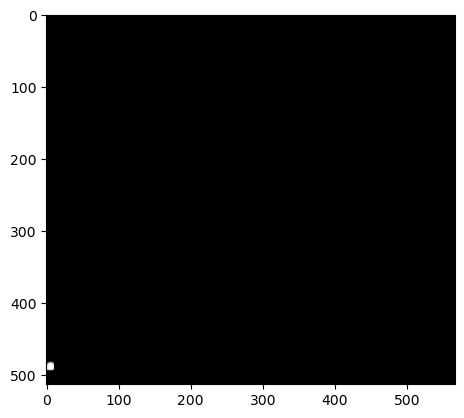

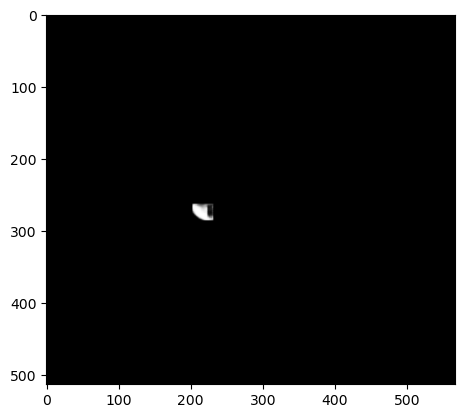

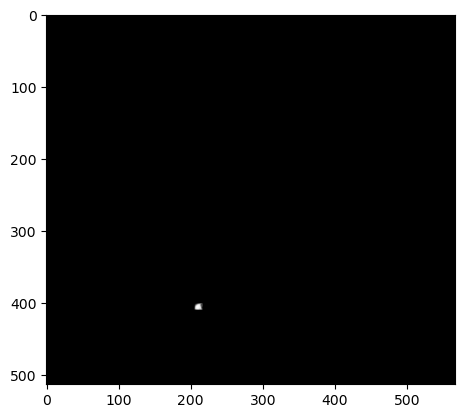

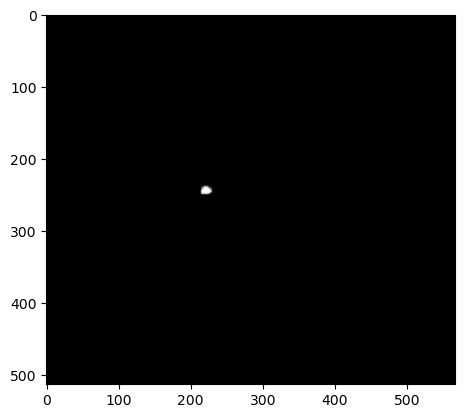

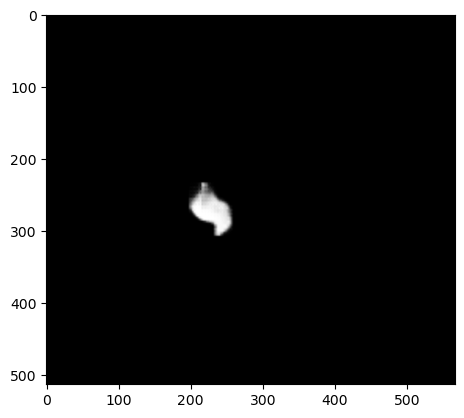

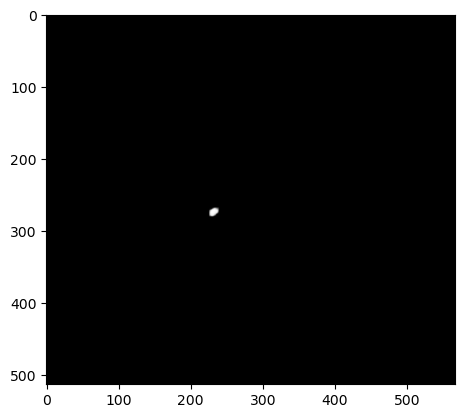

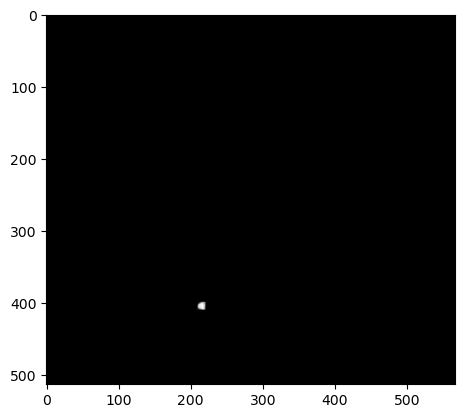

In [59]:
for i in range(21):
    plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()), cmap="gray")
    plt.show()